# RQs - LintQ - Analyzing Quantum Programs
This notebook contains the results of the analysis of quantum programs with the LintQ checkers.
The research questions and the main claims of the paper can be reproduced by running this code.

In [4]:
import project_path
from rdlib import *  # this imports the base libraries

import glob
from typing import Dict, List
import re
import yaml
import json
from tqdm import tqdm
from sarif import loader
import shutil
import random

from IPython.display import display

# DATA
SARIF_FOLDER = "../data/analysis_results/exp_v08/codeql_2024-03-01_08-43-53"
MAIN_FOLDER_DATA = "../data/datasets/exp_v08/files_selected"
PATH_LINTQ_SARIF = os.path.join(SARIF_FOLDER, "data.sarif")
DIR_DATASET_QISKIT = '../data/datasets/exp_v08'

PATH_LINTQ_ANNOTATION = os.path.join(SARIF_FOLDER, "Annotation_06_data_sample_representative_10.csv")
PATH_REAL_BUGS = "../bug_reports/LintQ Annotation 03-2024 - Real bugs.csv"


LOG_FILE_QUERIES = os.path.join(SARIF_FOLDER, '_log_with_compile.txt')
LOG_FILE_DB_CREATION = '../data/datasets/exp_v08/log_codeql.txt'

# IMAGES
OUTPUT_FOLDER = "paper_figures_revision"
import matplotlib.colors as mcolors
THEME_COLOR_LIGHT_HEX = '#FF5733'
THEME_COLOR_FULL_HEX = '#33FF57'
THEME_COLOR_ACCENT_HEX = '#3366FF'
THEME_COLOR_LIGHT_RGB = mcolors.hex2color(THEME_COLOR_LIGHT_HEX)
THEME_COLOR_FULL_RGB = mcolors.hex2color(THEME_COLOR_FULL_HEX)
THEME_COLOR_ACCENT_RGB = mcolors.hex2color(THEME_COLOR_ACCENT_HEX)

# SAMPLING
SAMPLE_AGAIN = False
FIXED_SAMPLE_SIZE = 10
CONFIDENCE_LEVEL = .90
MARGIN_ERROR = .10
RND_SEED = 42

# PRESENTATION PARAMETERS
LINTQ_CHECKER_TERM = "Analysis"

# RULES
NAME_MAPPING = {
    # measurement
    # ---
    'ql-double-measurement': 'DoubleMeas',
    'DoubleMeasurement.ql': 'DoubleMeas',
    # ---
    'ql-operation-after-measurement': 'OpAfterMeas',
    'OpAfterMeasurement.ql': 'OpAfterMeas',
    # ---
    'ql-measure-all-abuse': 'MeasAllAbuse',
    'MeasureAll.ql': 'MeasAllAbuse',
    # ---
    'ql-constant-classic-bit': 'ConstClasBit',
    'ConstantClassicBit.ql': 'ConstClasBit',
    # ---
    'ql-conditional-without-measurement': 'CondWoMeas',
    'ConditionalGateWithoutMeas.ql': 'CondWoMeas',

    # resources
    # ---
    'ql-unmeasurable-qubits': 'InsuffClasReg',
    'UnmeasurableQubits.ql': 'InsuffClasReg',
    # ---
    'ql-oversized-circuit': 'OversizedCircuit',
    'OversizedCircuit.ql': 'OversizedCircuit',
    # # ---

    # api constraints
    # ---
    'ql-op-after-optimization': 'OpAfterTransp',
    'OpAfterOptimization.ql': 'OpAfterTransp',
    # ---
    'ql-ghost-composition': 'GhostCompose',
    'GhostComposition.ql': 'GhostCompose',
    # ---
    'ql-deprecated-identity': 'OldIdenGate',
    'DeprecatedIdentity.ql': 'OldIdenGate',

}

RULE_NAME_MAPPING = {
    k: v for k, v in NAME_MAPPING.items() if k.startswith('ql-')
}
FILE_NAME_RULE_MAPPING = {
    k: v for k, v in NAME_MAPPING.items() if k.endswith('.ql')
}


# Abstraction
DETECTORS_FOLDER = '../qlint/codeql/src'
ABSTRACTION_FOLDER = '../qlint/codeql/lib/qiskit'

# Abstractions to consider
ABSTRACTIONS = [
    "QuantumCircuit",
    "RegisterV2",
    "QuantumRegisterV2",
    "ClassicalRegisterV2",
    "QubitUse",
    "QuantumOperator",
    "Measurement",
    "Subcircuit",
    "ComposeCall",
    "TranspileCall"
]

In [5]:
def get_results_from_sarif_path(sarif_path: str) -> Dict[str, Any]:
    """Extract the results from the sarif file as json."""
    with open(sarif_path, "r") as f:
        sarif_data = json.load(f)
    all_results = []
    n_runs = len(sarif_data['runs'])
    for i in range(n_runs):
        sarif_results = sarif_data["runs"][i]["results"]
        all_results.extend(sarif_results)
    return all_results


def get_df_from_sarif(sarif_results: List[Dict[str, Any]]):
    """Create a dataset from sarif results."""
    def process(record: Dict[str, Any]):
        """Parse some key info from the record."""
        region = record["locations"][0]["physicalLocation"].get("region", None)
        line, col = None, None
        if region:
            line = region.get("startLine", None)
            col = region.get("startColumn", None)
        return {
            "rule_id": record["ruleId"],
            "message": record["message"]["text"],
            "file": record["locations"][0]["physicalLocation"]["artifactLocation"]["uri"],
            "line": line,
            "col": col,
        }

    processed_results = [
        process(result)
        for result in sarif_results
    ]

    df_results = pd.DataFrame.from_records(processed_results)
    return df_results


def compute_representative_sample_size(
        population_size, margin_error=.05,confidence_level=.95,sigma=1/2):
    """Calculate sample size for a representative sample of the population.

    Credits: https://github.com/shawnohare/samplesize/blob/master/samplesize.py
    """

    alpha = 1 - (confidence_level)
    zdict = {
        .90: 1.645,
        .91: 1.695,
        .99: 2.576,
        .97: 2.17,
        .94: 1.881,
        .93: 1.812,
        .95: 1.96,
        .98: 2.326,
        .96: 2.054,
        .92: 1.751
    }
    if confidence_level in zdict:
        z = zdict[confidence_level]
    else:
        from scipy.stats import norm
        z = norm.ppf(1 - (alpha/2))
    N = population_size
    M = margin_error
    numerator = z**2 * sigma**2 * (N / (N-1))
    denom = M**2 + ((z**2 * sigma**2)/(N-1))
    return int(numerator/denom + 0.5)

res = compute_representative_sample_size(10000, margin_error=.05,confidence_level=.95,sigma=1/2)
assert res == 370

def get_file_extension_dictionary(dir: str) -> dict:
    """Get a dictionary {filename: its extension, etc.} form a directory."""
    file_extensions = {}
    for file in os.listdir(dir):
        base_name = os.path.splitext(file)[0]
        extension = os.path.splitext(file)[1]
        file_extensions[base_name] = extension
    return file_extensions


def count_files(folder: str, allowed_formats: List[str] = [".py", "ipynb"]):
    """Count how many files with the given extension are in the target folder."""
    files_extension = get_file_extension_dictionary(folder)
    return sum([
        1
        for file, extension in files_extension.items()
        if extension in allowed_formats
    ])


def compute_warnings_table(
        df_results: pd.DataFrame,
        rule_name_mapping: Dict[str, str],
        total_files_in_dataset: int,
        rule_term: str):
    """Compute the table in latex with number and percentage of warnings."""
    # compute: total sum of warnings
    df_abs = df_results.copy()
    df_abs = df_abs[["rule_id", "file"]]
    df_abs = df_abs.groupby("rule_id").count()
    df_abs = df_abs.reset_index(drop=False)
    df_abs = df_abs.rename(columns={"file": "tot_warnings"})

    # compute: files affected
    df = df_results.copy()
    df = df[["rule_id", "file"]]
    df = df.drop_duplicates()  # << difference
    df = df.groupby("rule_id").count()
    df = df.reset_index(drop=False)
    df = df.rename(columns={"file": "n_files_affected"})

    df = df.merge(df_abs, on="rule_id", how="left")
    if rule_name_mapping is not None:
        # add all the rules that are not in the dataframe with 0 warnings
        for rule in list(rule_name_mapping.keys()):
            if rule not in df['rule_id'].unique():
                print(f"WARN: no warnings for rule {rule}. Adding a 0 value.")
                df = pd.concat([df, pd.DataFrame([{
                    'rule_id': rule,
                    'tot_warnings': 0,
                    'n_files_affected': 0}])], ignore_index=True)
        # keep only rules that are in the mapping
        rules_not_in_mapping = \
            set(df['rule_id'].unique()) - set(rule_name_mapping.keys())
        if len(rules_not_in_mapping) > 0:
            print("WARN: some rules are not in the mapping. Discarding them.")
            print(rules_not_in_mapping)
            df = df[df['rule_id'].isin(rule_name_mapping.keys())]
        # rename column rules with mapping
        df['rule_id'] = df['rule_id'].apply(
            lambda e: rule_name_mapping[e]
            if e in rule_name_mapping.keys() else e)

    # rename column
    df['perc_of_affected_files'] = df['n_files_affected'].apply(
        lambda e: (int(e) / total_files_in_dataset) * 100)

    # compute the sample size


    # compute average and median of the perc_of_affected_files
    avg = df['perc_of_affected_files'].mean()
    median = df['perc_of_affected_files'].median()
    print("\\newcommand{\\avgWarningsPerc}{" + f"{avg:.2f}" + "\\%}")
    print("\\newcommand{\\medianWarningsPerc}{" + f"{median:.2f}" + "\\%}")

    # format as a percentage
    df['perc_of_affected_files'] = df['perc_of_affected_files'].apply(
        lambda e: "{:.2f}%".format(e))
    if rule_name_mapping is not None:
        # sort by canonical order
        categories = [cat for cat in rule_name_mapping.values()]
        df['rule_id'] = pd.Categorical(
            df['rule_id'], categories=categories)
        df = df.sort_values('rule_id')

    # cosmetic renaming
    mapping_column_to_name = {
        "rule_id": f"{rule_term} Name",
        "tot_warnings": "Tot. warnings",
        "perc_of_affected_files": "Files with warning",
    }
    # drop col not in the mapping
    df = df[mapping_column_to_name.keys()]
    df = df.rename(columns=mapping_column_to_name)


    table = df.to_latex(index=False, column_format="lrr")
    # replace % escaping
    table = table.replace("%", "\\%")
    print(table)
    display(df.reset_index(drop=True).head(20))
    return df


# Data Exploration: Statistics

In [3]:
TOTAL_FILES_IN_DATASET = count_files(
    folder=os.path.join(DIR_DATASET_QISKIT, "files_selected"),
    allowed_formats=[".py", "ipynb"]
)
print("\\newcommand{\\nTotalFiles}{" + f"{TOTAL_FILES_IN_DATASET:,}" + "}")

\newcommand{\nTotalFiles}{7,568}


In [4]:
sarif_results_lintq = get_results_from_sarif_path(PATH_LINTQ_SARIF)
df_results_lintq = get_df_from_sarif(sarif_results_lintq)

# keep relevant rule_id in RULE_NAME_MAPPING
df_results_lintq = df_results_lintq[
    df_results_lintq["rule_id"].isin(RULE_NAME_MAPPING.keys())]

df_results_lintq.head()


,rule_id,message,file,line,col
1912,ql-deprecated-identity,The deprecated iden() API is called.,01_classical_and_quantum_probability_distribut...,192.0,NaN
1913,ql-deprecated-identity,The deprecated iden() API is called.,022_03b_bernstein_vazirani_algorithm_f13ae3.py,39.0,9.0
1914,ql-deprecated-identity,The deprecated iden() API is called.,02b_deutsch_jozsa_algorithm_e9a399.py,46.0,9.0
1915,ql-deprecated-identity,The deprecated iden() API is called.,4_qbits_decoherence_9bbc1f.py,67.0,9.0
1916,ql-deprecated-identity,The deprecated iden() API is called.,4_qbits_decoherence_9bbc1f.py,195.0,9.0


# Data Exploration: Warning Rate

/tmp/ipykernel_3056770/3674610107.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(


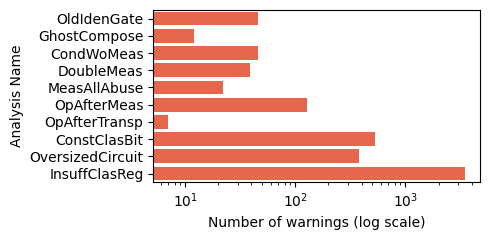

In [5]:
fig, ax = plt.subplots(figsize=(5, 2.5))

sns.countplot(
    data=df_results_lintq,
    color=THEME_COLOR_LIGHT_RGB,
    y="rule_id",
    ax=ax
)
# log scale
ax.set_xscale("log")
ax.set_xlabel("Number of warnings (log scale)")
ax.set_ylabel(LINTQ_CHECKER_TERM + " Name")
# replace the y labels with the RULE_NAME_MAPPING
original_labels = ax.get_yticklabels()
ax.set_yticklabels(
    [RULE_NAME_MAPPING[label.get_text()] for label in original_labels]
)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER, "EDA_fig_warnings_per_rule.pdf"))

In [6]:
df_warnings_table = compute_warnings_table(
    df_results=df_results_lintq,
    rule_name_mapping=RULE_NAME_MAPPING,
    total_files_in_dataset=TOTAL_FILES_IN_DATASET,
    rule_term=LINTQ_CHECKER_TERM
)


\newcommand{\avgWarningsPerc}{2.69\%}
\newcommand{\medianWarningsPerc}{0.36\%}
\begin{tabular}{lrr}
\toprule
Analysis Name & Tot. warnings & Files with warning \\
\midrule
DoubleMeas & 39 & 0.36\% \\
OpAfterMeas & 127 & 0.92\% \\
MeasAllAbuse & 22 & 0.26\% \\
ConstClasBit & 533 & 4.29\% \\
CondWoMeas & 46 & 0.22\% \\
InsuffClasReg & 3489 & 17.35\% \\
OversizedCircuit & 378 & 3.01\% \\
OpAfterTransp & 7 & 0.05\% \\
GhostCompose & 12 & 0.09\% \\
OldIdenGate & 46 & 0.37\% \\
\bottomrule
\end{tabular}



,Analysis Name,Tot. warnings,Files with warning
0,DoubleMeas,39,0.36%
1,OpAfterMeas,127,0.92%
2,MeasAllAbuse,22,0.26%
3,ConstClasBit,533,4.29%
4,CondWoMeas,46,0.22%
5,InsuffClasReg,3489,17.35%
6,OversizedCircuit,378,3.01%
7,OpAfterTransp,7,0.05%
8,GhostCompose,12,0.09%
9,OldIdenGate,46,0.37%


# Sampling for Inspection

In [7]:
# read the PATH_LINTQ_SARIF as a json
import json
with open(PATH_LINTQ_SARIF, "r") as f:
    sarif_raw_data = json.load(f)
    sarif_raw_data["runs"][0]["results"] = []
sarif_scaffold = sarif_raw_data.copy()

In [8]:
SAMPLE_AGAIN = False

if SAMPLE_AGAIN:
    sampled_results = []

    # for each rule, sort them alphabetically by filename,
    # then sample 10
    all_rules = df_results_lintq["rule_id"].unique()
    relevant_rules = [rule for rule in all_rules if rule in RULE_NAME_MAPPING.keys()]

    def sample(
            sarif_results: List[Dict[str, Any]],
            relevant_rules: List[str],
            fixed_sample_size=10,
            confidence_level=0.90,
            margin_error=0.10,
            random_seed=42,
            representative_sample_superset=False,):
        """Sample warnings from each rule."""
        sampled_results = []
        for rule in relevant_rules:
            # SET SEED FOR EACH RULE
            random.seed(random_seed)
            warnings_of_i_rule = [
                result
                for result in sarif_results
                if result["ruleId"] == rule
            ]
            # sort them by filename
            warnings_of_i_rule = sorted(
                warnings_of_i_rule,
                key=lambda x: x["locations"][0]["physicalLocation"]["artifactLocation"]["uri"]
            )
            representative_sample_size = compute_representative_sample_size(
                population_size=len(warnings_of_i_rule),
                margin_error=margin_error,
                confidence_level=confidence_level
            )
            # consider all
            sample_i_rule = warnings_of_i_rule
            # get the largest representative sample first
            if representative_sample_size > fixed_sample_size:
                if len(sample_i_rule) > representative_sample_size:
                    sample_i_rule = random.sample(sample_i_rule, representative_sample_size)

            # condition to trigger the fixed sample size
            if not representative_sample_superset:
                if len(sample_i_rule) > fixed_sample_size:
                    sample_i_rule = random.sample(sample_i_rule, fixed_sample_size)

            print(f"{len(warnings_of_i_rule)} >> {len(sample_i_rule)}\t ({rule})")
            sampled_results.extend(sample_i_rule)
        return sampled_results

    sarif_sample_fixed = sample(
        sarif_results=sarif_results_lintq,
        relevant_rules=relevant_rules,
        fixed_sample_size=FIXED_SAMPLE_SIZE
    )
    df_results_sample_fixed = get_df_from_sarif(sarif_sample_fixed)
    print(f"FIXED: total sample size: {len(df_results_sample_fixed)}")
    print('-' * 80)

    sarif_sample_representative = sample(
        sarif_results=sarif_results_lintq,
        relevant_rules=relevant_rules,
        fixed_sample_size=FIXED_SAMPLE_SIZE,
        representative_sample_superset=True,
    )
    df_results_sample_representative = get_df_from_sarif(sarif_sample_representative)
    print(f"REPRESENTATIVE: total sample size: {len(df_results_sample_representative)}")
    print('-' * 80)

    # check that all the fixed size records are in the representative one
    df_intersection = df_results_sample_fixed.merge(
        df_results_sample_representative,
        how="inner",
        on=["rule_id", "message", "file", "line", "col"],
        suffixes=("_fixed", "_representative")
    )
    assert len(df_intersection) == len(df_results_sample_fixed)
    # export - FIXED,
    to_export = [
        # FIXED SIZE
        {
            'sarif_results': sarif_sample_fixed,
            'prefix': f"data_sample_fixed_{FIXED_SAMPLE_SIZE}"
        },
        # REPRESENTATIVE
        {
            'sarif_results': sarif_sample_representative,
            'prefix': f"data_sample_representative_{FIXED_SAMPLE_SIZE}"
        },
        # DELTA
        {
            'sarif_results': [
                result for result in sarif_sample_representative
                if result not in sarif_sample_fixed],
            'prefix': f"data_sample_delta_{FIXED_SAMPLE_SIZE}"
        }
    ]

    for i_to_export in to_export:
        print("-" * 80)
        new_sarif_i = sarif_scaffold.copy()
        i_results = i_to_export["sarif_results"]
        i_prefix = i_to_export["prefix"]
        new_sarif_i["runs"][0]["results"] = i_results
        with open(os.path.join(SARIF_FOLDER, f"{i_prefix}.sarif"), "w") as f:
            json.dump(new_sarif_i, f)
        # copy all the files in a dedicated folder
        # create folder in the sarif one with pathlib
        i_subfolder_path = os.path.join(SARIF_FOLDER, i_prefix)
        pathlib.Path(i_subfolder_path).mkdir(parents=True, exist_ok=True)
        # add a gitignore in the subfolder
        with open(os.path.join(i_subfolder_path, ".gitignore"), "w") as f:
            f.write("*")
        i_all_filenames = [
            result["locations"][0]["physicalLocation"]["artifactLocation"]["uri"]
            for result in i_results
        ]
        i_ORIGINAL_filepaths = [
            os.path.join(MAIN_FOLDER_DATA, filename) for filename in i_all_filenames]
        print(i_ORIGINAL_filepaths[:5])
        # copy from original to the i_subfolder
        for filepath in tqdm(i_ORIGINAL_filepaths):
            shutil.copy(filepath, i_subfolder_path)
        # create dataframe
        i_df = get_df_from_sarif(i_results)
        i_df.to_csv(
            os.path.join(SARIF_FOLDER, f"{i_prefix}.csv"), index=False)
        print(
            f"Exported {len(i_results)} results to " +
            "{i_filename}.sarif and {i_filename}.csv")
        print(f"Exported {len(i_ORIGINAL_filepaths)} files to {os.path.basename(i_subfolder_path)}")



# RQ1: Modeling Info: Abstractions and Queries


In [9]:
def read_files(folder: str, extension: str = ".ql") -> Dict[str, str]:
    """Read all files with the given extension in the folder and subfolders."""
    ql_files = {}
    for file in glob.glob(folder + f'/**/*{extension}', recursive=True):
        with open(file, 'r') as f:
            content = f.read()
            ql_files[file.replace(folder, "")] = content
    return ql_files

def get_abstractions_used(content: str) -> List[str]:
    """Get the abstractions used in the given content."""
    abstractions = []
    for line in content.splitlines():
        if line.startswith('import'):
            abstraction = line.split(' ')[1]
            abstractions.append(abstraction)
    return abstractions

In [10]:
query_files = read_files(
    folder=DETECTORS_FOLDER, extension='.ql')
abstraction_files = read_files(
    folder=ABSTRACTION_FOLDER, extension='.qll')

print(f'Number of queries: {len(query_files)}')
print(f'Number of abstractions: {len(abstraction_files)}')
all_query_names = list(query_files.keys())
print(all_query_names)

all_abstractions_names = list(abstraction_files.keys())
print(all_abstractions_names)

Number of queries: 31
Number of abstractions: 13
['/Backend/InitWithoutTranspilation.ql', '/Backend/MeasWithStatevector.ql', '/Measurement/OpAfterMeasurement.ql', '/Measurement/MeasureAll.ql', '/Measurement/DoubleMeasurement.ql', '/Measurement/ConditionalGateWithoutMeas.ql', '/Measurement/OpAfterMeasurementGeneral.ql', '/Qsmell/NoAlignmentLogicalPhysical.ql', '/Qsmell/NonParametrizedCircuit.ql', '/Extra/SimulatorSizeOverflow.ql', '/Extra/DeprecatedCircuitMethod.ql', '/Extra/GhostQASMImport.ql', '/Extra/SuperfluousOp.ql', '/Extra/TranspileWithoutLayout.ql', '/Extra/ExecuteWithSeed.ql', '/Extra/MultipleSubmission.ql', '/Extra/DeprecatedIdentity.ql', '/Extra/ImproperDraw.ql', '/Extra/SuperfluousOpPrecise.ql', '/Resource/OversizedCircuit.ql', '/Resource/ConstantClassicBit.ql', '/Resource/UnmeasurableQubits.ql', '/Simulation/InvalidPauliSyntaxError.ql', '/Simulation/InvalidPauliErrorSize.ql', '/Vulnerability/TokenLeakage.ql', '/Metrics/CircuitSize.ql', '/Interconnection/IncompatibleComposit

### RQ1.A Which abstractions are used in the different queries?

In [11]:
def get_abstractions_from_qll(content: str) -> List[str]:
    """Get the abstractions used in the given content.

    It uses regex."""
    # get: class TestClass()
    classes = re.findall(r'^class (\w+)', content, re.MULTILINE)
    return classes

def get_predicates_from_qql(content: str) -> List[str]:
    """Get the predicates used in the given content.

    It uses regex."""
    # get also: predicate testPredicate(
    predicates = re.findall(r'^predicate (\w+)', content, re.MULTILINE)
    return predicates

all_abstraction_defined = []
for abstraction_file in abstraction_files.values():
    all_abstraction_defined += get_abstractions_from_qll(abstraction_file)
    all_abstraction_defined += get_predicates_from_qql(abstraction_file)

print(f'Number of abstractions defined: {len(all_abstraction_defined)}')
print(all_abstraction_defined)

Number of abstractions defined: 104
['QuantumRegisterV2', 'ClassicalRegisterV2', 'ImplicitCircuitQubitDefinition', 'ImplicitCircuitClbitDefinition', 'ImplicitRegisterQubitDefinition', 'ImplicitRegisterClbitDefinition', 'ExplicitSingleQubitDefinition', 'ExplicitSingleClbitDefinition', 'isIntegerParameterOfCall', 'IBMCloudTokenSink', 'PauliString', 'Backend', 'BackendRunViaRunCall', 'BackendRunViaExecuteCall', 'BackendResult', 'Statevector', 'PauliError', 'EmptySetForString', 'EmptySetForInt', 'EmptySetForRegisterV2', 'EmptySetForQuantumCircuit', 'QubitUseViaAttribute', 'QubitUseViaAppend', 'QubitUseViaMeasureAll', 'OperatorSpecificationAttributeName', 'OperatorSpecificationObjectName', 'OperatorSpecificationReset', 'OperatorSpecificationMeasureAll', 'OperatorSpecificationMeasure', 'OperatorSpecificationInitialize', 'OperatorSpecificationUnitaryGateObj', 'OperatorSpecificationUnitaryCall', 'OperatorSpecificationSingleQubitNoParam', 'OperatorSpecificationPGate', 'OperatorSpecificationRXGa

In [12]:
def check_abstractions_used(abstraction: List[str], content: str) -> bool:
    """Check if the given abstraction is used in the content.

    Via regex.
    """
    abstractions_used = []
    for a in abstraction:
        if re.search(rf'\b{a}\b', content):
            abstractions_used.append(a)
    return abstractions_used

def get_color_for_abstr_family(
        df: pd.DataFrame,
        col_name: str,
        format_str: str = 'hex',):
    """Get a color dict mapping each abstraction to a color.

    Nota that this mapping is based on the abstraction name.
    If not specified it is grey.
    """
    # create thematic groups for source
    if format_str == 'hex':
        color_themes = {
            "pauli": "#dc267f",
            # purple
            "compos": "#785ef0",
            "transp": "#785ef0",
            "iden": "#785ef0",
            "run": "#785ef0",
            # resources
            "insuf": "#fe6100",
            "oversize": "#fe6100",
            # yellow
            "[^u]?meas": "#ffb001",
            "[^u]?const": "#ffb001",
        }
    elif format_str == 'rgb':
        color_themes = {
            "pauli": "rgb(220, 38, 127)",
            "compos": "rgb(120, 94, 240)",
            "insuf": "rgb(254, 97, 0)",
            "oversize": "rgb(254, 97, 0)",
            "[^u]?meas": "rgb(255, 176, 1)",
        }
    per_family_color = {}
    for row in df.iterrows():
        query_name = row[1][col_name]
        # default
        per_family_color[query_name] = "grey"
        for k in color_themes.keys():
            if re.search(k, query_name.lower()):
                per_family_color[query_name] = color_themes[k]
                break
    return per_family_color

query_to_abstraction = {}

for query_name, query_content in query_files.items():
    abstractions_used = check_abstractions_used(
        abstraction=all_abstraction_defined,
        content=query_content)
    if abstractions_used:
        base_name = os.path.basename(query_name)
        if base_name in FILE_NAME_RULE_MAPPING:
            base_name = FILE_NAME_RULE_MAPPING[base_name]
        query_to_abstraction[base_name] = abstractions_used
        print(f'{query_name}: {abstractions_used}')

/Backend/InitWithoutTranspilation.ql: ['Backend', 'QuantumCircuit', 'TranspiledCircuit', 'Gate']
/Backend/MeasWithStatevector.ql: ['Backend', 'BackendRunViaRunCall', 'Statevector', 'QuantumCircuit', 'TranspiledCircuit', 'Gate']
/Measurement/OpAfterMeasurement.ql: ['mayFollow', 'mayFollowDirectly', 'sortedInOrder', 'Gate']
/Measurement/MeasureAll.ql: ['QuantumCircuit', 'MeasurementAll']
/Measurement/DoubleMeasurement.ql: ['mayFollowDirectly', 'Gate']
/Measurement/ConditionalGateWithoutMeas.ql: ['SubCircuit', 'Gate']
/Measurement/OpAfterMeasurementGeneral.ql: ['mayFollow', 'sortedInOrder', 'Gate']
/Qsmell/NonParametrizedCircuit.ql: ['QuantumCircuit']
/Extra/SimulatorSizeOverflow.ql: ['Backend', 'QuantumCircuit', 'Gate']
/Extra/DeprecatedCircuitMethod.ql: ['Backend', 'QuantumCircuit', 'Gate']
/Extra/GhostQASMImport.ql: ['Backend', 'QuantumCircuit', 'Gate']
/Extra/SuperfluousOp.ql: ['Backend', 'SubCircuit', 'QuantumCircuitConstructor', 'QuantumCircuit', 'mayFollow', 'Gate']
/Extra/Transpil

,source,target,type,value
0,InitWithoutTranspilation.ql,Backend,use,1
1,InitWithoutTranspilation.ql,QuantumCircuit,use,1
2,InitWithoutTranspilation.ql,TranspiledCircuit,use,1
3,InitWithoutTranspilation.ql,Gate,use,1
4,MeasWithStatevector.ql,Backend,use,1


\newcommand{\avgAbstractionsUsedPerQuery}{3.1}
\newcommand{\avgQueriesSupportedPerAbstraction}{5.5}
Number of null values: 57
Number of null values: 0
['DoubleMeas', 'OpAfterMeas', 'MeasAllAbuse', 'ConstClasBit', 'CondWoMeas', 'InsuffClasReg', 'OversizedCircuit', 'OpAfterTransp', 'GhostCompose', 'OldIdenGate']


/tmp/ipykernel_3056770/3533632057.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  use_relationship_per_query = df_abstractions.groupby('source').count()['value']


,source,target,type,value
47,OldIdenGate,Backend,use,1
49,OldIdenGate,Gate,use,1
48,OldIdenGate,QuantumCircuit,use,1
85,GhostCompose,SubcircuitComposition,use,1
84,GhostCompose,SubcircuitComposition,use,1
87,OpAfterTransp,Gate,use,1
86,OpAfterTransp,TranspiledCircuit,use,1
60,OversizedCircuit,SubcircuitComposition,use,1
61,OversizedCircuit,QuantumCircuit,use,1
62,OversizedCircuit,QuantumCircuit,use,1


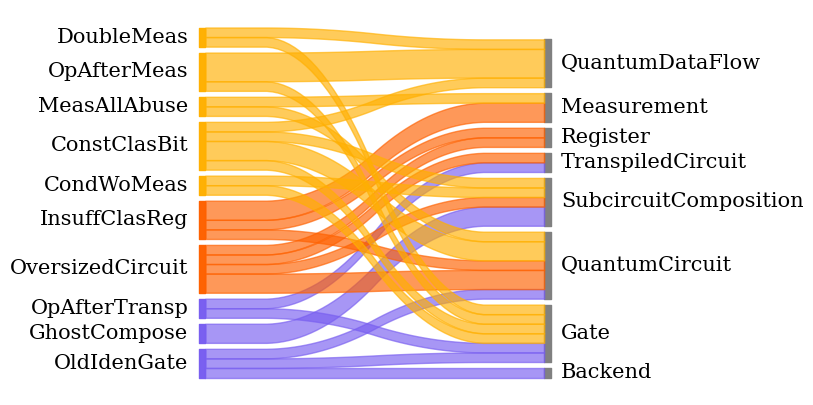

In [13]:
FAMILY_NAME_SUBCIRC = 'SubcircuitComposition'
FAMILY_NAME_QDF = "QuantumDataFlow"
FAMILY_NAME_MEAS = "Measurement"
FAMILY_NAME_QC = "QuantumCircuit"
ABSTRACTION_MAPPING = {
    "MeasureGateCall": FAMILY_NAME_MEAS,
    "MeasurementAll": FAMILY_NAME_MEAS,
    "mayFollow": FAMILY_NAME_QDF,
    "mayFollowDirectly": FAMILY_NAME_QDF,
    "sortedInOrder": FAMILY_NAME_QDF,
    "ComposeCall": FAMILY_NAME_SUBCIRC,
    "ReturnsNewValue": FAMILY_NAME_SUBCIRC,
    "SubCircuit": FAMILY_NAME_SUBCIRC,
    "QuantumRegisterV2": "Register",
    "QuantumCircuit": FAMILY_NAME_QC,
    "QuantumCircuitConstructor": FAMILY_NAME_QC
}

# # get matplotlib rc configuration
# rc = plt.rcParams.copy()

from pySankey.sankey import sankey
# source,target,type,value

records = []
for query_name, abstractions in query_to_abstraction.items():
    for abstraction in abstractions:
        records.append({
            'source': query_name,
            'target': abstraction,
            'type': 'use',
            'value': 1,
        })
df_abstractions = pd.DataFrame.from_records(records)
# map abstraction names
df_abstractions['target'] = df_abstractions['target'].apply(
    lambda e: ABSTRACTION_MAPPING[e] if e in ABSTRACTION_MAPPING else e)

display(df_abstractions.head())
# sort by canonical order
df_abstractions['source'] = pd.Categorical(
    df_abstractions['source'],
    categories=list(set(NAME_MAPPING.values()))
)
df_abstractions = df_abstractions.sort_values('source', ascending=False)
df_abstractions.head()
# compute the average number of records per source
use_relationship_per_query = df_abstractions.groupby('source').count()['value']
#print(use_relationship_per_query)
avg_use_relationship_per_query = use_relationship_per_query.mean()
print("\\newcommand{\\avgAbstractionsUsedPerQuery}{" + f"{avg_use_relationship_per_query:.1f}" + "}")
avg_use_relationship_per_abstraction = df_abstractions.groupby('target').count()['value'].mean()
print("\\newcommand{\\avgQueriesSupportedPerAbstraction}{" + f"{avg_use_relationship_per_abstraction:.1f}" + "}")


# check null values, print and drop them
print(f"Number of null values: {df_abstractions.isnull().sum().sum()}")
df_abstractions = df_abstractions.dropna()
print(f"Number of null values: {df_abstractions.isnull().sum().sum()}")

per_family_color = get_color_for_abstr_family(
    df=df_abstractions,
    col_name='source',
)

# colorDict: yellow for target and blue for source
colorDict = {
    #**{k: 'slateblue' for k in df_abstractions['source'].unique()},
    **per_family_color,
    **{k: 'gray' for k in df_abstractions['target'].unique()}
}

# sort by canonical order
canonical_order = list(RULE_NAME_MAPPING.values())
print(canonical_order)
df_abstractions['source'] = pd.Categorical(
    df_abstractions['source'],
    categories=canonical_order)
df_abstractions = df_abstractions.sort_values('source', ascending=False)

display(df_abstractions)
sankey(
    left=df_abstractions['source'],
    right=df_abstractions['target'],
    aspect=20,
    colorDict=colorDict,
    fontsize=15,
)
plt.gcf().set_size_inches(5, 5)
plt.savefig(
    os.path.join(OUTPUT_FOLDER, 'sankey_abstraction_v2.pdf'),
    bbox_inches='tight')

# go back to the initial rc configuration
# plt.rcParams.update(rc)

10
\newcommand{\avgLoCQuery}{10.6}
\newcommand{\minLoCQuery}{3}
\newcommand{\maxLoCQuery}{17}


/tmp/ipykernel_3056770/2837402366.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


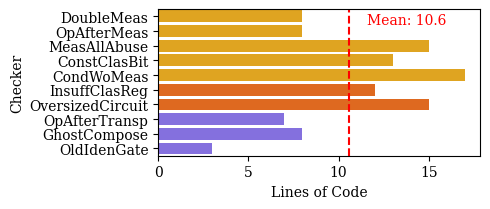

In [14]:
SHOW_QUERIES_DEBUG = False

records = []
for query_name, query_content in query_files.items():
    # count the lines in the content excluding the imports and the comment lines
    # comment start with: /* or * or //
    # imports start with: import
    lines = query_content.splitlines()
    lines = [
        line for line in lines
        # use regex to ensure we account for spaces
        if not re.match(r'^\s*import', line) and
        not re.match(r'^\s*//', line) and
        not re.match(r'^\s*\*', line) and
        not re.match(r'^\s*/\*', line)
    ]
    # remove empty lines
    lines = [l for l in lines if l != '']
    loc = len(lines)
    if SHOW_QUERIES_DEBUG:
        print("\n".join(lines))
        print(query_name, loc)
        # check that none of the line is longer than 80 chars
        for line in lines:
            if len(line) > 80:
                print("___________________ line too long: ", line)
    base_query_name = os.path.basename(query_name)
    # keep only if it is in the mapping (aka relevant queries)
    if base_query_name in FILE_NAME_RULE_MAPPING:
        records.append({
            'query_name': FILE_NAME_RULE_MAPPING[base_query_name],
            'loc': loc
        })

df_loc_queries = pd.DataFrame.from_records(records)
print(len(df_loc_queries))
# sort by canonical order
categories = [
    cat for cat in RULE_NAME_MAPPING.values()
    if "QSmell" not in cat
]
df_loc_queries['query_name'] = pd.Categorical(
    df_loc_queries['query_name'], categories=categories)
df_loc_queries = df_loc_queries.sort_values('query_name')

per_family_color = get_color_for_abstr_family(
    df=df_loc_queries,
    col_name='query_name',
)

# plot the lines of code histogram
fig, ax = plt.subplots(figsize=(5, 2.2))
sns.barplot(
    data=df_loc_queries,
    y='query_name',
    x='loc',
    palette=per_family_color.values(),
    # sort
    #order=df_loc_queries.sort_values('loc', ascending=True)['query_name'],
)
ax.set_xlabel('Lines of Code')
ax.set_ylabel('Checker')
mean_value = df_loc_queries['loc'].mean()
# add red line for the mean
ax.axvline(mean_value, color='red', linestyle='--')
# plot the label of the mean
ax.text(
    mean_value + 1,
    0.5,
    f'Mean: {mean_value:.1f}',
    color='red',
)
plt.tight_layout()
fig.savefig(
    os.path.join(OUTPUT_FOLDER, 'loc_queries.pdf')
)
print("\\newcommand{\\avgLoCQuery}{" + f"{mean_value:.1f}" + "}")
min_value = df_loc_queries['loc'].min()
print("\\newcommand{\\minLoCQuery}{" + f"{min_value:.0f}" + "}")
max_value = df_loc_queries['loc'].max()
print("\\newcommand{\\maxLoCQuery}{" + f"{max_value:.0f}" + "}")

# RQ2: Real Bugs

In [15]:
df_real_bugs_reported = pd.read_csv(PATH_REAL_BUGS)
# keep only those reported by last version of detectors
present_col_name = [
    c for c in df_real_bugs_reported.columns if "Present_in" in c][0]
df_real_bugs_reported = df_real_bugs_reported[
    df_real_bugs_reported[present_col_name] == "yes"
]
# map longer output -> Long. Out.
df_real_bugs_reported["manifestation"] = df_real_bugs_reported["manifestation"].apply(
    lambda x: "LongOut" if x == "Longer output" else x
)
# map rule_id
df_real_bugs_reported["rule_id"] = df_real_bugs_reported["rule_id"].apply(
    lambda x: RULE_NAME_MAPPING[x] if x in RULE_NAME_MAPPING else x
)
# mapt the status
# Reported -> Report.
# Confirmed -> Confir
# Fixed -> Fix
mapping_status = {
    "Reported": "Reported",
    "Confirmed": "Confirmed",
    "Fixed": 'Fixed'
}
df_real_bugs_reported["status"] = df_real_bugs_reported["status"].apply(
    lambda x: mapping_status[x] if x in mapping_status else x
)
# sort them by status: Fixed, Confirmed, Reported, Not Fix
df_real_bugs_reported["status"] = pd.Categorical(
    df_real_bugs_reported["status"],
    categories=["Fixed", "Confirmed", "Reported", "Not Fix"]
)
df_real_bugs_reported = df_real_bugs_reported.sort_values("status")

print(df_real_bugs_reported.columns)
mapping_numbers = {
    "1": "One",
    "2": "Two",
    "3": "Thr",
    "4": "Fou",
    "5": "Fiv",
    "6": "Six",
    "7": "Sev",
    "8": "Eig",
    "9": "Nin",
    "0": "Zer",
}
# display(df_real_bugs_reported)

df_real_bugs_reported = df_real_bugs_reported.reset_index(drop=True)
# display(df_real_bugs_reported)
# assign an increasing ID starting from 1
df_real_bugs_reported["ID"] = df_real_bugs_reported.index + 1



for i, row in df_real_bugs_reported.iterrows():
    msg = row["issue"]
    # remove underscores
    msg = msg.replace("_", "")
    for k, v in mapping_numbers.items():
        msg = msg.replace(k, v)
    # msg = msg.translate(str.maketrans('', '', string.punctuation))
    # msg = ''.join([w.capitalize() for w in msg.lower().split()])
    # msg = ''.join(ch for ch in msg if ch.isalpha())
    if msg != "":
        print("\\newcommand{\\ID" + msg + "}{" + str(row["ID"]) + "}")

# Keep only relevant columns columns
df_real_bugs_reported = df_real_bugs_reported[
    ["ID", "rule_id", "description", "manifestation", "issue", "status"]
]

# convert issue number in apex
df_real_bugs_reported["issue"] = df_real_bugs_reported["issue"].apply(
    lambda x: "$^{" + x+ "}$" if x != "" else x
)

# rename columns
# rule_id > Analysis Name
# description > Description
# status -> Status
# manifestation -> Manif.
df_real_bugs_reported.rename(
    columns={
        "rule_id": LINTQ_CHECKER_TERM,
        "description": "Description",
        "status": "Status",
        "manifestation": "Manif.",
        "issue": "Issue"
    }, inplace=True
)
display(df_real_bugs_reported)

# drop Issue
df_real_bugs_reported.drop(columns=["Issue"], inplace=True)
display(df_real_bugs_reported)

# export to latex
table = df_real_bugs_reported.to_latex(
    # index=False, column_format="p{0.1cm}p{2cm}p{6.2cm}p{0.8cm}p{0.8cm}p{1.4cm}")
    index=False, column_format="@{}rllll@{}")
# escape %
table = table.replace("%", "\\%")
table = table.replace("_", "\_")

print(table)


Index(['issue', 'rule_id', 'description', 'file', 'line',
       'Present_in_codeql_2023-09-18_17-17-54', 'status', 'manifestation',
       'issue_link'],
      dtype='object')
\newcommand{\IDZerSixfeSixZerZerNinSixThr}{1}
\newcommand{\IDZerSixOneThrbaEigZerNinZer}{2}
\newcommand{\IDZerSixOneThrbaEigZerOneZerSev}{3}
\newcommand{\IDZerSixOneThrbaEigZerOneZerSev}{4}
\newcommand{\IDZerEigcaFiveSixSixThrFiv}{5}
\newcommand{\IDZerEigcFivZerSevThrFouFouOneTwo}{6}
\newcommand{\IDZerEigNinTwoSevSixaOneThrOne}{7}
\newcommand{\IDZerSixFoucNinFouFouThrThrFiv}{8}
\newcommand{\IDZerEigcFoucThrFoufFivNin}{9}
\newcommand{\IDZerEigNinTwoThrTwoeaFivFiv}{10}
\newcommand{\IDZerSixFivFivfdZerSevTwoFiv}{11}
\newcommand{\IDZerSixSevafThrThrTwoThrFiv}{12}
\newcommand{\IDZerSixZerNinbeZerThrOneNin}{13}
\newcommand{\IDZerSixdfSixZerEigfThrTwoTwo}{14}
\newcommand{\IDZerEigOneTwofbFivZerSevZer}{15}


,ID,Analysis,Description,Manif.,Issue,Status
0,1,DoubleMeas,Redundant measurment,Silent,$^{06_fe6009_63}$,Fixed
1,2,GhostCompose,Missing compose assignment in a test case,Silent,$^{06_13ba80_90}$,Fixed
2,3,GhostCompose,Missing compose assignment in a test case,Silent,$^{06_13ba80_107}$,Fixed
3,4,GhostCompose,Missing compose assignment in a test case,Silent,$^{06_13ba80_107}$,Fixed
4,5,MeasAllAbuse,Measure all generates a twice as long output,Silent,$^{08_ca5e66_35}$,Fixed
5,6,MeasAllAbuse,Measure all generates a twice as long output,Silent,$^{08_c50734_412}$,Confirmed
6,7,OpAfterMeas,"Non idiomatic teleportation, lack of c_if",Silent,$^{08_9276a1_31}$,Confirmed
7,8,InsuffClasReg,Unused qubit,Silent,$^{06_4c9443_35}$,Reported
8,9,OpAfterTransp,Measure gate added to a transpiled circuit,Silent,$^{08_c4c34f_59}$,Reported
9,10,OpAfterTransp,Grover algo: measure gate added after transp.,Silent,$^{08_9232ea_55}$,Reported


,ID,Analysis,Description,Manif.,Status
0,1,DoubleMeas,Redundant measurment,Silent,Fixed
1,2,GhostCompose,Missing compose assignment in a test case,Silent,Fixed
2,3,GhostCompose,Missing compose assignment in a test case,Silent,Fixed
3,4,GhostCompose,Missing compose assignment in a test case,Silent,Fixed
4,5,MeasAllAbuse,Measure all generates a twice as long output,Silent,Fixed
5,6,MeasAllAbuse,Measure all generates a twice as long output,Silent,Confirmed
6,7,OpAfterMeas,"Non idiomatic teleportation, lack of c_if",Silent,Confirmed
7,8,InsuffClasReg,Unused qubit,Silent,Reported
8,9,OpAfterTransp,Measure gate added to a transpiled circuit,Silent,Reported
9,10,OpAfterTransp,Grover algo: measure gate added after transp.,Silent,Reported


\begin{tabular}{@{}rllll@{}}
\toprule
ID & Analysis & Description & Manif. & Status \\
\midrule
1 & DoubleMeas & Redundant measurment & Silent & Fixed \\
2 & GhostCompose & Missing compose assignment in a test case & Silent & Fixed \\
3 & GhostCompose & Missing compose assignment in a test case & Silent & Fixed \\
4 & GhostCompose & Missing compose assignment in a test case & Silent & Fixed \\
5 & MeasAllAbuse & Measure all generates a twice as long output & Silent & Fixed \\
6 & MeasAllAbuse & Measure all generates a twice as long output & Silent & Confirmed \\
7 & OpAfterMeas & Non idiomatic teleportation, lack of c\_if & Silent & Confirmed \\
8 & InsuffClasReg & Unused qubit & Silent & Reported \\
9 & OpAfterTransp & Measure gate added to a transpiled circuit & Silent & Reported \\
10 & OpAfterTransp & Grover algo: measure gate added after transp. & Silent & Reported \\
11 & MeasAllAbuse & Measure all $\rightarrow$ twice as long output (Bell pair) & LongOut & Reported \\
12 & MeasAl

# RQ3: Precision and Recall

## Precision

In [16]:
df_annotations = pd.read_csv(PATH_LINTQ_ANNOTATION)
# keep only those in the mapping RULE_MAPPING
# the value in the column rule_id must belong to the keys of RULE_MAPPING
df_annotations = df_annotations[
    df_annotations["rule_id"].isin(RULE_NAME_MAPPING.keys())]

display(df_annotations.head())

COL_AGREED_ANNOTATION = "Resolution"
COL_RULE = "rule_id"
COL_AGREEMENT_REACHED = "same_decision"

df_doubly_annotated = df_annotations[
    df_annotations.apply(
        lambda row: (
            row["Annotator_1"] in ["TP", "NW", "FP"] and
            row["Annotator_2"] in ["TP", "NW", "FP"]
        ), axis=1
    )]

df_doubly_annotated[COL_AGREEMENT_REACHED] = df_doubly_annotated.apply(
    lambda row: row["Annotator_1"] == row["Annotator_2"], axis=1)

doubly_annotated_count = df_doubly_annotated[
    COL_AGREEMENT_REACHED].astype(str).value_counts()
total_doubly_annotated = \
    doubly_annotated_count["True"] + doubly_annotated_count["False"]
print(f"Total doubly annotated: {total_doubly_annotated}")

percentage_agreement = doubly_annotated_count["True"] / total_doubly_annotated
print(f"Percentage agreement: {percentage_agreement}")

# print("\\newcommand{\\kappa}{" + f"{choen_kappa:.2f}" + "}")
print("\\newcommand{\\percAgreement}{" + f"{percentage_agreement * 100:.1f}" + "\\%}")


,rule_id,message,file,line,col,Annotator_1,Annotator_2,Resolution,Last Round,issue_local,reported_as,reason
0,ql-measure-all-abuse,measure_all() on the circuit 'circuit' (at loc...,bell_states_example_55fd07.py,20,5.0,TP,TP,TP,TP,06_55fd07_25,new_report,RMA1
1,ql-measure-all-abuse,measure_all() on the circuit 'qc' (at location...,polarization_20rotator_20angle_25374b.py,20,5.0,TP,TP,TP,TP,08_25374b_20,new_report,RMA1
2,ql-measure-all-abuse,measure_all() on the circuit 'quantum_circuit'...,quantum_entanglement_f902fe.py,23,NaN,TP,TP,TP,TP,08_f902fe_23,new_report,RMA1
3,ql-operation-after-measurement,Operation 'cz' on qubit 0 after measurement at...,quantumteleportationprotocol_7da521.py,56,NaN,TP,TP,TP,TP,087da521_56,new_report,ROAM1
4,ql-double-measurement,Two consecutive measurements on qubit '0' at l...,quantum_e3f4e0.py,74,5.0,TP,TP,TP,TP,08_e3f4e0_74,new_report,RDM6


Total doubly annotated: 45
Percentage agreement: 0.9555555555555556
\newcommand{\percAgreement}{95.6\%}


/tmp/ipykernel_3056770/1031054005.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_doubly_annotated[COL_AGREEMENT_REACHED] = df_doubly_annotated.apply(


Considering noteworthy as FP
Average precision: 1.0


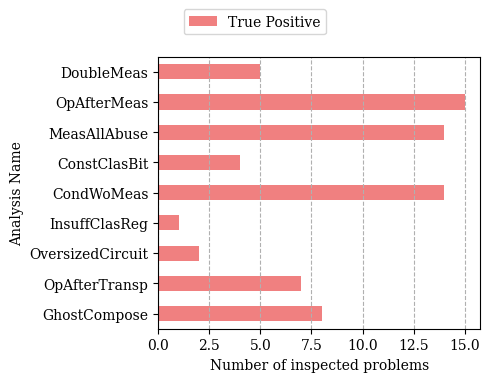

In [17]:
# focus on the last round annotation
COL_AGREED_ANNOTATION = "Last Round"
# # mark whatever is not agreed on as "FP"
# df_annotations[COL_AGREED_ANNOTATION] = df_annotations.apply(
#     lambda row: row["Annotator_1"] if row[COL_AGREEMENT_REACHED] else "FP", axis=1)

CONSIDERED_NW_IN_PRECISION = False

if df_annotations[COL_AGREED_ANNOTATION].nunique() == 3:
    COLORS = ["lightcoral", "lightblue", "springgreen"]
else:
    COLORS = ["lightcoral", "springgreen"]

df_stacked_hist = df_annotations.copy()
# keep COL_RULE, COL_AGREED_ANNOTATION columns
df_stacked_hist = df_stacked_hist[[COL_RULE, COL_AGREED_ANNOTATION, "message"]]
# count for each category
df_stacked_hist = df_stacked_hist.groupby(
    [COL_RULE, COL_AGREED_ANNOTATION]).count()

# rename message > count and reset index
df_stacked_hist = df_stacked_hist.rename(columns={"message": "count"})
df_stacked_hist = df_stacked_hist.reset_index(drop=False)
# convert rule_id in categorical and sort
df_stacked_hist[COL_RULE] = pd.Categorical(
    df_stacked_hist[COL_RULE], categories=list(RULE_NAME_MAPPING.keys()))
df_stacked_hist = df_stacked_hist.sort_values(COL_RULE, ascending=True)
# rename the rule_id with their mapping
df_stacked_hist[COL_RULE] = df_stacked_hist[COL_RULE].apply(
    lambda e: RULE_NAME_MAPPING[e] if e in RULE_NAME_MAPPING.keys() else e)

# put the different annotation categories as columns
df_pivoted = df_stacked_hist.pivot(
    index=COL_RULE, columns=COL_AGREED_ANNOTATION, values='count')
# rename categories
MAPPING_CATEGORY_NAMES = {
    "TP": "True Positive",
    "NW": "Noteworthy",
    "FP": "False Positive"
}
df_pivoted = df_pivoted.rename(columns=MAPPING_CATEGORY_NAMES)
# flip vertically
df_pivoted = df_pivoted.iloc[::-1]

fig, ax = plt.subplots(figsize=(5, 4))
df_pivoted.plot(
    kind='barh',
    stacked=True,
    color=COLORS,
    ax=ax
)

# remove title from the legend
plt.legend(
    title=None,
    loc='upper center', bbox_to_anchor=(0.3, 1.2), ncol=3)

# add the labels
plt.xlabel("Number of inspected problems")
plt.ylabel(LINTQ_CHECKER_TERM + " Name")

# add vertical grid
plt.grid(axis='x', linestyle='--')

# STATS
if CONSIDERED_NW_IN_PRECISION:
    print(f"Considering noteworthy as TP")
    tp_labels = ["TP", "NW"]
else:
    print(f"Considering noteworthy as FP")
    tp_labels = ["TP"]
average_precision = df_annotations.groupby(
    COL_RULE).apply(
        lambda df: (df[COL_AGREED_ANNOTATION].isin(tp_labels)).mean()).mean()
print(f"Average precision: {average_precision}")


plt.tight_layout()
fig.savefig(
    os.path.join(OUTPUT_FOLDER, "precision_estimate_abs.pdf"),
    bbox_inches="tight")

In [18]:
df_precision_with_subannotations = df_pivoted.reset_index()
# fill na in all columns, excepts for rule_id
for col in df_precision_with_subannotations.columns:
    if col != COL_RULE:
        df_precision_with_subannotations[col] = df_precision_with_subannotations[col].fillna(0)
df_precision_with_subannotations


Last Round,rule_id,True Positive
0,GhostCompose,8
1,OpAfterTransp,7
2,OversizedCircuit,2
3,InsuffClasReg,1
4,CondWoMeas,14
5,ConstClasBit,4
6,MeasAllAbuse,14
7,OpAfterMeas,15
8,DoubleMeas,5


In [19]:
precision_series = df_annotations.groupby(
    COL_RULE).apply(
        lambda df: (df[COL_AGREED_ANNOTATION].isin(tp_labels)).mean())
df_precision_table = pd.DataFrame(precision_series).reset_index(drop=False)
# rename col 1 -> Precision
df_precision_table.rename(columns={0: "precision"}, inplace=True)
# \nInspectedWarnings{}
n_inspected_warnings = df_annotations.shape[0]
print("\\newcommand{\\nInspectedWarnings}{" + f"{n_inspected_warnings:,}" + "}")
n_true_positives = df_annotations[COL_AGREED_ANNOTATION].isin(tp_labels).sum()
print("\\newcommand{\\nTruePositivesLintQ}{" + f"{n_true_positives}" + "}")

full_dataset_precision = df_annotations[COL_AGREED_ANNOTATION].isin(tp_labels).mean()
print("\\newcommand{\\allTPOverAllWarningsLintQ}{" + f"{full_dataset_precision * 100:.1f}" + "\%}")
median_precision = df_precision_table['precision'].median() * 100
print("\\newcommand{\\medianPrecisionLintQ}{" + f"{median_precision:.1f}" + "\%}")
mean_precision = df_precision_table['precision'].mean() * 100
print("\\newcommand{\\avgPrecisionLintQ}{" + f"{mean_precision:.1f}" + "\%}")
min_precision = df_precision_table['precision'].min() * 100
print("\\newcommand{\\minPrecisionLintQ}{" + f"{min_precision:.1f}" + "\%}")
max_precision = df_precision_table['precision'].max() * 100
print("\\newcommand{\\maxPrecisionLintQ}{" + f"{max_precision:.1f}" + "\%}")

# keep only checkers with more than 50% precision
from statistics import mean

checkers_above_average = list(df_precision_table[
    df_precision_table['precision'] > 0.5][COL_RULE])
# print(checkers_above_average)
print("\\newcommand{\\nCheckersAboveFiftyPrecision}{" + f"{len(checkers_above_average)}" + "}")

df_annotations_best_checkers = df_annotations[
    df_annotations[COL_RULE].isin(checkers_above_average)]
df_precision_table_best_checkers = df_precision_table[
    df_precision_table[COL_RULE].isin(checkers_above_average)]

full_dataset_precision_best = df_annotations_best_checkers[
    COL_AGREED_ANNOTATION].isin(tp_labels).mean()
n_true_positives_best = df_annotations_best_checkers[
    COL_AGREED_ANNOTATION].isin(tp_labels).sum()
n_inspected_warnings_best = df_annotations_best_checkers.shape[0]
print("\\newcommand{\\nInspectedWarningsBestCheckers}{" + f"{n_inspected_warnings_best:,}" + "}")
print("\\newcommand{\\nTruePositivesLintQBestCheckers}{" + f"{n_true_positives_best}" + "}")
print("\\newcommand{\\allTPOverAllWarningsLintQBestCheckers}{" + f"{full_dataset_precision_best * 100:.1f}" + "\%}")
median_precision_best = df_precision_table_best_checkers['precision'].median() * 100
print("\\newcommand{\\medianPrecisionLintQBestCheckers}{" + f"{median_precision_best:.1f}" + "\%}")
mean_precision_best = df_precision_table_best_checkers['precision'].mean() * 100
print("\\newcommand{\\avgPrecisionLintQBestCheckers}{" + f"{mean_precision_best:.1f}" + "\%}")
min_precision_best = df_precision_table_best_checkers['precision'].min() * 100
print("\\newcommand{\\minPrecisionLintQBestCheckers}{" + f"{min_precision_best:.1f}" + "\%}")
max_precision_best = df_precision_table_best_checkers['precision'].max() * 100
print("\\newcommand{\\maxPrecisionLintQBestCheckers}{" + f"{max_precision_best:.1f}" + "\%}")


# rename precision with Precision
df_precision_table.rename(columns={"precision": "Precision"}, inplace=True)
# rename rule_id with mapping
df_precision_table[COL_RULE] = df_precision_table[COL_RULE].apply(
    lambda e: RULE_NAME_MAPPING[e] if e in RULE_NAME_MAPPING.keys() else e)
# format with %
df_precision_table["Precision"] = df_precision_table["Precision"].apply(
    lambda e: "{:.1f}%".format(e * 100))

# merge df_precision_table and df_warnings_table on the first column
df_precision_table_renamed = df_precision_table.rename(
    columns={COL_RULE: LINTQ_CHECKER_TERM + " Name"})
df_precision_warnings_table = df_warnings_table.merge(
    df_precision_table_renamed, on=LINTQ_CHECKER_TERM + " Name", how="left")

# merge with df_precision_with_subannotations
df_precision_with_subannotations_renamed = df_precision_with_subannotations.rename(
    columns={COL_RULE: LINTQ_CHECKER_TERM + " Name"})
df_precision_warnings_table = df_precision_warnings_table.merge(
    df_precision_with_subannotations_renamed, on=LINTQ_CHECKER_TERM + " Name", how="left")

# add progress bar: \dbTP{6}\dbNW{2}\dbFP{2}
def create_progress_bar(row):
    """Create a progressbar using TP, NW, FP as a percentage."""
    output = ""
    max_length = 10
    fp = int(row["False Positive"])
    nw = int(row["Noteworthy"])
    tp = int(row["True Positive"])
    total = tp + nw + fp
    perc_fp = fp / total * max_length
    perc_nw = nw / total * max_length
    perc_tp = max_length - perc_fp - perc_nw
    output += "\\dbFP{" + f"{perc_fp:.2f}" + "}"
    output += "\\dbNW{" + f"{perc_nw:.2f}" + "}"
    output += "\\dbTP{" + f"{perc_tp:.2f}" + "}"
    output += " " + f"{fp:.0f}/{nw:.0f}/{tp:.0f}"
    return output


# take values from the columns: False Positive	Noteworthy	True Positive
df_precision_warnings_table['FP / NW / TP'] = df_precision_warnings_table.apply(
    lambda row: create_progress_bar(row), axis=1)

# drop those columns
df_precision_warnings_table = df_precision_warnings_table.drop(
    columns=["False Positive", "Noteworthy", "True Positive"])


# rename Files with warning -> % Files
# Precision -> Prec.
df_precision_warnings_table.rename(
    columns={
        "Files with warning": "% Files",
    }, inplace=True)

display(df_precision_warnings_table)

# export to latex
table = df_precision_warnings_table.to_latex(
    index=False, column_format="lp{1.75cm}p{0.9cm}|p{1cm}l@{}")
# escape %
table = table.replace("%", "\\%")
print(table)


\newcommand{\nInspectedWarnings}{70}
\newcommand{\nTruePositivesLintQ}{70}
\newcommand{\allTPOverAllWarningsLintQ}{100.0\%}
\newcommand{\medianPrecisionLintQ}{100.0\%}
\newcommand{\avgPrecisionLintQ}{100.0\%}
\newcommand{\minPrecisionLintQ}{100.0\%}
\newcommand{\maxPrecisionLintQ}{100.0\%}
\newcommand{\nCheckersAboveFiftyPrecision}{9}
\newcommand{\nInspectedWarningsBestCheckers}{70}
\newcommand{\nTruePositivesLintQBestCheckers}{70}
\newcommand{\allTPOverAllWarningsLintQBestCheckers}{100.0\%}
\newcommand{\medianPrecisionLintQBestCheckers}{100.0\%}
\newcommand{\avgPrecisionLintQBestCheckers}{100.0\%}
\newcommand{\minPrecisionLintQBestCheckers}{100.0\%}
\newcommand{\maxPrecisionLintQBestCheckers}{100.0\%}


KeyError: 'False Positive'

## Recall

In [ ]:
## BEFORE REVISION
# PATH_BUGS4Q_ANNOTATION_LINTQ = "../data/analysis_results/Bugs4Q-Framework_08_08_2023/codeql_2023-09-20_13-47-05/01_Annotation_bugs4q.csv"
PATH_BUGS4Q_ANNOTATION_LINTQ = "../data/analysis_results/Bugs4Q-Framework_08_08_2023/codeql_2024-03-01_14-47-34/02_Annotation_bugs4q.csv"
COL_AGREED_ANNOTATION = "Annotator_1"
COL_RULE = "rule_id"
TOTAL_FILES_IN_BUGS4Q = 42

df_annotations_bugs4q = pd.read_csv(PATH_BUGS4Q_ANNOTATION_LINTQ)
n_warnings_bugs4q = len(df_annotations_bugs4q)
print("\\newcommand{\\nWarningsBugsFourQ}{" + f"{n_warnings_bugs4q}" + "}")

n_TP_bugs4q = len(df_annotations_bugs4q[
    df_annotations_bugs4q[COL_AGREED_ANNOTATION] == "TP"])
print("\\newcommand{\\nTPBugsFourQ}{" + f"{n_TP_bugs4q}" + "}")

n_FP_bugs4q = len(df_annotations_bugs4q[
    df_annotations_bugs4q[COL_AGREED_ANNOTATION] == "FP"])
print("\\newcommand{\\nFPBugsFourQ}{" + f"{n_FP_bugs4q}" + "}")

n_NW_bugs4q = len(df_annotations_bugs4q[
    df_annotations_bugs4q[COL_AGREED_ANNOTATION] == "NW"])
print("\\newcommand{\\nNWBugsFourQ}{" + f"{n_NW_bugs4q}" + "}")

# precision per rule_id
df_annotations_bugs4q['rule_id'].unique()
df_annotations_bugs4q['rule_id'].value_counts()

# compute precision per rule
dict_precision_per_rule = {}
for rule_id in df_annotations_bugs4q['rule_id'].unique():
    df_rule = df_annotations_bugs4q[df_annotations_bugs4q['rule_id'] == rule_id]
    n_TP = len(df_rule[df_rule[COL_AGREED_ANNOTATION] == "TP"])
    n_FP = len(df_rule[df_rule[COL_AGREED_ANNOTATION] == "FP"])
    n_NW = len(df_rule[df_rule[COL_AGREED_ANNOTATION] == "NW"])
    precision = n_TP / (n_TP + n_FP + n_NW)
    dict_precision_per_rule[rule_id] = precision
    print("\\newcommand{\\precRule" + rule_id.replace("-", "") + "BugsFourQ}{" + f"{precision*100:.1f}\\%" + "}")

# number of files where is_bug_for_bugs4q is true
n_buggy_files_detected = len(df_annotations_bugs4q[
    df_annotations_bugs4q['is_bug_for_bugs4q'] == True]['Location'].unique())
print("\\newcommand{\\nBuggyFilesDetectedBugsFourQ}{" + f"{n_buggy_files_detected}" + "}")

recall = n_buggy_files_detected / TOTAL_FILES_IN_BUGS4Q
print("\\newcommand{\\recallBugsFourQ}{" + f"{recall*100:.1f}\\%" + "}")




\newcommand{\nWarningsBugsFourQ}{31}
\newcommand{\nTPBugsFourQ}{9}
\newcommand{\nFPBugsFourQ}{18}
\newcommand{\nNWBugsFourQ}{4}
\newcommand{\precRuleqlconstantclassicbitBugsFourQ}{100.0\%}
\newcommand{\precRuleqlmeasureallabuseBugsFourQ}{100.0\%}
\newcommand{\precRuleqloperationaftermeasurementBugsFourQ}{100.0\%}
\newcommand{\precRuleqldeprecatedidentityBugsFourQ}{100.0\%}
\newcommand{\precRuleqloversizedcircuitBugsFourQ}{66.7\%}
\newcommand{\precRuleqlunmeasurablequbitsBugsFourQ}{0.0\%}
\newcommand{\nBuggyFilesDetectedBugsFourQ}{3}
\newcommand{\recallBugsFourQ}{7.1\%}


# RQ4: Complement Related Work

## QCheckers

In [20]:
FOLDER_WITH_QCHECKER_WARNINGS = "../data/datasets/exp_v08/qchecker"
COL_AGREED_ANNOTATION = "Last Round"

RULE_NAME_MAPPING_QCHECKER = {
    "IG": "IncorrectUseGate",
    "MI": "MeasurementIssue",
    "IIS": "IncorrectInitState",
    "PE": "ParameterError",
    "CM": "CommandMisuse",
    "CE": "CallError",
    "QE": "QasmError",
    "DO": "DiscardedOrder"
}

# check how many files are in all the subfolders ending in "_error"
error_folders = glob.glob(
    os.path.join(FOLDER_WITH_QCHECKER_WARNINGS, "*_errors"))
dict_error_per_rule_qchecker = {}
for folder_path in error_folders:
    folder_name = os.path.basename(folder_path)
    rule_name = folder_name.split("_")[0]
    n_files = len(os.listdir(folder_path))
    dict_error_per_rule_qchecker[rule_name] = n_files
print(dict_error_per_rule_qchecker)

# scan all the .sarif files and join them
all_sarif_files = glob.glob(
    os.path.join(FOLDER_WITH_QCHECKER_WARNINGS, "*.sarif"))

df_results_qchecker = pd.concat([
    get_df_from_sarif(get_results_from_sarif_path(sarif_file))
    for sarif_file in all_sarif_files
])

# unique values rule_id
print(df_results_qchecker["rule_id"].unique())

# remove file:/// prefix
df_results_qchecker["file"] = df_results_qchecker["file"].apply(
    lambda e: e.replace("file:///", ""))

print(f"Total warnings: {len(df_results_qchecker)}")
display(df_results_qchecker.head())


compute_warnings_table(
    df_results=df_results_qchecker,
    rule_name_mapping=RULE_NAME_MAPPING_QCHECKER,
    total_files_in_dataset=TOTAL_FILES_IN_DATASET,
    rule_term="Rule"
)

{'DO': 4133, 'IM': 4133, 'CM': 4133, 'QE': 4133, 'CE': 4133, 'IIS': 4136, 'IG': 4133, 'MI': 4133, 'PE': 4133}
['DO' 'IG' 'IIS' 'PE' 'IM' 'QE' 'CE']
Total warnings: 3812


,rule_id,message,file,line,col
0,DO,"print(""Votre tâche (job) a l'identifiant à ret...",qiskit_job_execute_a1a942.py,35.0,1
1,DO,middle.iden(q),t1_f9bfa8.py,42.0,1
2,DO,print('Not all keys are identical. This sh...,task_2_4f46b2.py,60.0,1
3,DO,full_basis = np.identity(n),item3_weighted_ssvqe_2_824c3d.py,70.0,1
4,DO,"Hm = sum([pauli_x(i, -1) for i in range(n_qubi...",07_variational_circuits_qiskit_8df8ee.py,67.0,1


WARN: no warnings for rule MI. Adding a 0 value.
WARN: no warnings for rule CM. Adding a 0 value.
WARN: some rules are not in the mapping. Discarding them.
{'IM'}
\newcommand{\avgWarningsPerc}{2.94\%}
\newcommand{\medianWarningsPerc}{1.39\%}
\begin{tabular}{lrr}
\toprule
Rule Name & Tot. warnings & Files with warning \\
\midrule
IncorrectUseGate & 310 & 2.05\% \\
MeasurementIssue & 0 & 0.00\% \\
IncorrectInitState & 1282 & 8.47\% \\
ParameterError & 884 & 5.84\% \\
CommandMisuse & 0 & 0.00\% \\
CallError & 958 & 6.33\% \\
QasmError & 18 & 0.12\% \\
DiscardedOrder & 110 & 0.73\% \\
\bottomrule
\end{tabular}



,Rule Name,Tot. warnings,Files with warning
0,IncorrectUseGate,310,2.05%
1,MeasurementIssue,0,0.00%
2,IncorrectInitState,1282,8.47%
3,ParameterError,884,5.84%
4,CommandMisuse,0,0.00%
5,CallError,958,6.33%
6,QasmError,18,0.12%
7,DiscardedOrder,110,0.73%


,Rule Name,Tot. warnings,Files with warning
2,IncorrectUseGate,310,2.05%
7,MeasurementIssue,0,0.00%
3,IncorrectInitState,1282,8.47%
5,ParameterError,884,5.84%
8,CommandMisuse,0,0.00%
0,CallError,958,6.33%
6,QasmError,18,0.12%
1,DiscardedOrder,110,0.73%


## QSmell

In [21]:
FOLDER_WITH_QSMELL_WARNINGS = "../data/datasets/exp_v08/qsmell"

RULE_NAME_MAPPING_QSMELL = {
    'LPQ': 'LogicalPhysicalQubits',
    'NC': 'NonParameterizedCircuit',
}

# LOAD QSMELL WARNINGS
all_csv_files = [
    os.path.join(FOLDER_WITH_QSMELL_WARNINGS, f)
    for f in os.listdir(FOLDER_WITH_QSMELL_WARNINGS)
    if f.endswith(".csv")
]
df_results_qsmell = pd.concat([pd.read_csv(f) for f in all_csv_files])
df_results_qsmell.rename(columns={
    "metric": "rule_id", "filename": "file"
}, inplace=True)
# add default line column to 1
df_results_qsmell["line"] = 1
df_results_qsmell["col"] = 1


def derive_message(row):
    if row["value"] == "error":
        return "error"
    if int(row["value"]) >= 1:
        if row["rule_id"] == "NC":
            return f"{row['rule_id']} smell - " + \
                "Non-parameterized Circuit"
        if row["rule_id"] == "LPQ":
            return f"{row['rule_id']} smell - " + \
                "No-alignment between the Logical and Physical Qubits"
    return "no smell"

df_results_qsmell['message'] = df_results_qsmell.apply(derive_message, axis=1)

# count the errors per rule
dict_error_per_rule_qsmell = df_results_qsmell[
    df_results_qsmell["message"] == "error"
].groupby("rule_id").size().to_dict()
print(dict_error_per_rule_qsmell)

# drop errors
df_results_qsmell = df_results_qsmell[df_results_qsmell["message"] != "error"]
# drop no smells
df_results_qsmell = df_results_qsmell[df_results_qsmell["message"] != "no smell"]

# keep only rule_id, msg, file, line, col and drop remaining columns
df_results_qsmell = df_results_qsmell[
    ["rule_id", "message", "file", "line", "col"]]
display(df_results_qsmell.head())

print(f"Total warnings: {len(df_results_qsmell)}")

compute_warnings_table(
    df_results=df_results_qsmell,
    rule_name_mapping=RULE_NAME_MAPPING_QSMELL,
    total_files_in_dataset=TOTAL_FILES_IN_DATASET,
    rule_term="Rule"
)

{'LPQ': 21, 'NC': 21}


,rule_id,message,file,line,col
5,LPQ,LPQ smell - No-alignment between the Logical a...,unittest_7125fc.py,1,1
21,LPQ,LPQ smell - No-alignment between the Logical a...,4_c6ba6b.py,1,1
38,LPQ,LPQ smell - No-alignment between the Logical a...,test_4a62dd.py,1,1
41,LPQ,LPQ smell - No-alignment between the Logical a...,our_vqe_gjg_591c88.py,1,1
44,LPQ,LPQ smell - No-alignment between the Logical a...,alternating_operator_63165f.py,1,1


Total warnings: 2916
\newcommand{\avgWarningsPerc}{19.27\%}
\newcommand{\medianWarningsPerc}{19.27\%}
\begin{tabular}{lrr}
\toprule
Rule Name & Tot. warnings & Files with warning \\
\midrule
LogicalPhysicalQubits & 698 & 9.22\% \\
NonParameterizedCircuit & 2218 & 29.31\% \\
\bottomrule
\end{tabular}



,Rule Name,Tot. warnings,Files with warning
0,LogicalPhysicalQubits,698,9.22%
1,NonParameterizedCircuit,2218,29.31%


,Rule Name,Tot. warnings,Files with warning
0,LogicalPhysicalQubits,698,9.22%
1,NonParameterizedCircuit,2218,29.31%


## Pylint

In [22]:
# print the list of only those files that have received TP from our annotation
TP_annotations_files = list(df_annotations[
    df_annotations[COL_AGREED_ANNOTATION] == "TP"
]["file"].unique())
print(
    "NOTE: add this field to the yaml config file of Pylint "
    "(e.g., pylint_vXX.yaml in the config folder)")
print("then run: python -m competitors.pylint.run_pylint_folder config/competitors/pylint_v08.yaml")
print("subset_files_to_analyze:")
for file in TP_annotations_files:
    print(f"  - {file}")

NOTE: add this field to the yaml config file of Pylint (e.g., pylint_vXX.yaml in the config folder)
then run: python -m competitors.pylint.run_pylint_folder config/competitors/pylint_v08.yaml
subset_files_to_analyze:
  - bell_states_example_55fd07.py
  - polarization_20rotator_20angle_25374b.py
  - quantum_entanglement_f902fe.py
  - quantumteleportationprotocol_7da521.py
  - quantum_e3f4e0.py
  - real_system_c4c34f.py
  - mnist_dd2c4f.py
  - test_sdk_352e8e.py
  - one_qubit_fb6117.py
  - groverfuncs_9232ea.py
  - quantumteleportation_2823d6.py
  - h2evo_6bb46f.py
  - neoh2evo_28b965.py
  - ch_3_28325b.py
  - interferibmc_c22d6b.py
  - test_mc_gate_13ba80.py
  - rsa_breaker_4_bit_0f27ff.py
  - qrng_9498d5.py
  - matchgate_tools_mudground_checkpoint_a852d9.py
  - test_circuit_load_from_qasm_bf30ab.py
  - test_circuit_qasm_ae5268.py
  - test_decompose_78559e.py
  - test_structure_aaba85.py
  - test_qasm_simulator_edd048.py
  - test_parse_counts_0953d6.py
  - source_59a0eb956a0d4e6b8720f27

In [23]:
FOLDER_WITH_PYLINT_WARNINGS = "../data/datasets/exp_v08/pylint"

sarif_results_pylint = get_results_from_sarif_path(
    os.path.join(FOLDER_WITH_PYLINT_WARNINGS, "data.sarif"))
df_results_pylint = get_df_from_sarif(sarif_results_pylint)

# transform the file keeping only filename
df_results_pylint["file"] = df_results_pylint["file"].apply(
    lambda e: os.path.basename(e))
# convert line to int
df_results_pylint["line"] = df_results_pylint["line"].astype(int)

display(df_results_pylint.head())
print(f"Total warnings: {len(df_results_pylint)}")

compute_warnings_table(
    df_results=df_results_pylint,
    rule_name_mapping=None,
    total_files_in_dataset=len(TP_annotations_files),
    rule_term="Rule"
)

,rule_id,message,file,line,col
0,C0301,Line too long (114/100).,task_2_4f46b2.py,60,1
1,C0304,Final newline missing.,task_2_4f46b2.py,64,1
2,C0114,Missing module docstring.,task_2_4f46b2.py,1,1
3,C0103,"Constant name ""alice_key"" doesn't conform to U...",task_2_4f46b2.py,5,1
4,C0103,"Constant name ""bob_key"" doesn't conform to UPP...",task_2_4f46b2.py,6,1


Total warnings: 9958
\newcommand{\avgWarningsPerc}{26.47\%}
\newcommand{\medianWarningsPerc}{7.02\%}
\begin{tabular}{lrr}
\toprule
Rule Name & Tot. warnings & Files with warning \\
\midrule
C0103 & 1560 & 191.23\% \\
C0114 & 138 & 242.11\% \\
C0115 & 28 & 14.04\% \\
C0116 & 438 & 124.56\% \\
C0121 & 3 & 5.26\% \\
C0123 & 2 & 3.51\% \\
C0200 & 31 & 21.05\% \\
C0201 & 1 & 1.75\% \\
C0206 & 6 & 5.26\% \\
C0209 & 53 & 42.11\% \\
C0301 & 1599 & 161.40\% \\
C0302 & 5 & 8.77\% \\
C0303 & 2954 & 149.12\% \\
C0304 & 36 & 63.16\% \\
C0305 & 54 & 94.74\% \\
C0321 & 8 & 7.02\% \\
C0325 & 28 & 19.30\% \\
C0410 & 1 & 1.75\% \\
C0411 & 107 & 96.49\% \\
C0412 & 58 & 59.65\% \\
C0413 & 390 & 115.79\% \\
C0415 & 6 & 1.75\% \\
C1802 & 1 & 1.75\% \\
C1803 & 3 & 1.75\% \\
C2401 & 10 & 3.51\% \\
C3001 & 8 & 5.26\% \\
E0102 & 7 & 7.02\% \\
E0401 & 197 & 124.56\% \\
E0402 & 8 & 12.28\% \\
E0601 & 6 & 8.77\% \\
E0602 & 149 & 57.89\% \\
E0611 & 89 & 64.91\% \\
E0633 & 1 & 1.75\% \\
E1101 & 221 & 61.40\% \\
E110

,Rule Name,Tot. warnings,Files with warning
0,C0103,1560,191.23%
1,C0114,138,242.11%
2,C0115,28,14.04%
3,C0116,438,124.56%
4,C0121,3,5.26%
5,C0123,2,3.51%
6,C0200,31,21.05%
7,C0201,1,1.75%
8,C0206,6,5.26%
9,C0209,53,42.11%


,Rule Name,Tot. warnings,Files with warning
0,C0103,1560,191.23%
1,C0114,138,242.11%
2,C0115,28,14.04%
3,C0116,438,124.56%
4,C0121,3,5.26%
...,...,...,...
96,W1309,12,1.75%
97,W1310,1,1.75%
98,W1401,3,3.51%
99,W1514,30,8.77%


## Compute Overlap on TP

In [24]:
df_lintq_tp  = df_annotations[df_annotations[COL_AGREED_ANNOTATION] == "TP"]

# keep only those in the mapping RULE_MAPPING
# the value in the column rule_id must belong to the keys of RULE_MAPPING
df_lintq_tp = df_lintq_tp[
    df_lintq_tp["rule_id"].isin(RULE_NAME_MAPPING.keys())]

n_lintq_tps = len(df_lintq_tp)

relevant_files_w_tp = df_lintq_tp["file"].unique()
n_relevant_files_w_tp = len(relevant_files_w_tp)

# check the intersection between these files and lines and the dataset
# of qsmell and qchecker
df_lintq_tp = df_lintq_tp[["rule_id", "file", "line", "message"]]
# convert line to int
df_lintq_tp["line"] = df_lintq_tp["line"].astype(int)

COMPETITORS = [
    {"name": "QChecker", "df": df_results_qchecker},
    {"name": "QSmell", "df": df_results_qsmell},
    {"name": "Pylint", "df": df_results_pylint}
]
display(df_lintq_tp.head())

dfs_competitors = []

latex_commands = ""
for competitor in COMPETITORS:
    name = competitor["name"]
    df = competitor["df"]

    df_on_relevant_files = df[df["file"].isin(relevant_files_w_tp)]
    print(f"Total {name} warnings: {len(df_on_relevant_files)}")
    latex_commands += "\\newcommand{\\nWarningsOnLintQTPwith" + name + "}{" + f"{len(df_on_relevant_files)}" + "}\n"
    n_files_flagged_by_competitor = len(df_on_relevant_files["file"].unique())
    flag_ratio = n_files_flagged_by_competitor / n_relevant_files_w_tp
    perc_flag_ratio = flag_ratio * 100
    print(f"Ratio of {name} warnings on relevant files: {flag_ratio}")
    # latex_commands += "\\newcommand{\\percRatio" + name + "OnTP}{" + f"{perc_flag_ratio:.1f}" + "\\%}\n"

    print(f"Checking {name}")
    # convert line to int
    df["line"] = df["line"].astype(int)
    df = df[["rule_id", "file", "line", "message"]]
    # merge
    df_competitor_pointing_to_lintq_lines = df_lintq_tp.merge(
        df,
        how="inner",
        on=["file", "line"],
        suffixes=("_lintq", "_prior_work"),
    )
    df_competitor_pointing_to_lintq_lines["tool"] = name
    # drop duplicate lines
    df_competitor_pointing_to_lintq_lines = \
        df_competitor_pointing_to_lintq_lines.drop_duplicates()
    # count
    overlap_size = len(df_competitor_pointing_to_lintq_lines)
    print(f"Overlapping {name}: {overlap_size}")
    latex_commands += "\\newcommand{\\nWarningsOnLintQTPwith" + name + "Overlap}{" + f"{overlap_size}" + "}\n"
    warnings_overlooked = n_lintq_tps - overlap_size
    latex_commands += "\\newcommand{\\nWarningsOnLintQTPwith" + name + "Missed}{" + f"{warnings_overlooked}" + "}\n"
    display(df_competitor_pointing_to_lintq_lines)
    dfs_competitors.append(df_competitor_pointing_to_lintq_lines)


# concatenate the competitors
df_competitors = pd.concat(dfs_competitors)
# export as csv
df_competitors.to_csv(
    os.path.join(OUTPUT_FOLDER, "df_competitors.csv"), index=False)

# read annotated competitors
df_annotated_competitors = pd.read_csv(
    os.path.join(OUTPUT_FOLDER, "df_competitor_annotate_overlap.csv"))

# keep those found by any of the tool
df_annotated_competitors = df_annotated_competitors[
    df_annotated_competitors["same_issue"] == "yes"]
# deduplicate the rows referring to the same LintQ issue
df_annotated_competitors = df_annotated_competitors.drop_duplicates(
    subset=["file", "line", "rule_id_lintq"])
n_overlooked_by_all_competitors = n_lintq_tps - len(df_annotated_competitors)
latex_commands += "\\newcommand{\\nTPsMissedByAllCompetitors}{" + f"{n_overlooked_by_all_competitors}" + "}\n"
perc_missed_by_all_competitors = n_overlooked_by_all_competitors / n_lintq_tps * 100
latex_commands += "\\newcommand{\\percTPsMissedByAllCompetitors}{" + f"{perc_missed_by_all_competitors:.1f}" + "\\%}\n"

n_found_by_at_least_one_competitor = len(df_annotated_competitors)
latex_commands += "\\newcommand{\\nTPsFoundByAtLeastOneCompetitor}{" + f"{n_found_by_at_least_one_competitor}" + "}\n"
perc_found_by_at_least_one_competitor = n_found_by_at_least_one_competitor / n_lintq_tps * 100
latex_commands += "\\newcommand{\\percTPsFoundByAtLeastOneCompetitor}{" + f"{perc_found_by_at_least_one_competitor:.1f}" + "\\%}\n"

print("-" * 80)
print("Latex")
print(latex_commands)



,rule_id,file,line,message
0,ql-measure-all-abuse,bell_states_example_55fd07.py,20,measure_all() on the circuit 'circuit' (at loc...
1,ql-measure-all-abuse,polarization_20rotator_20angle_25374b.py,20,measure_all() on the circuit 'qc' (at location...
2,ql-measure-all-abuse,quantum_entanglement_f902fe.py,23,measure_all() on the circuit 'quantum_circuit'...
3,ql-operation-after-measurement,quantumteleportationprotocol_7da521.py,56,Operation 'cz' on qubit 0 after measurement at...
4,ql-double-measurement,quantum_e3f4e0.py,74,Two consecutive measurements on qubit '0' at l...


Total QChecker warnings: 74
Ratio of QChecker warnings on relevant files: 0.43859649122807015
Checking QChecker
Overlapping QChecker: 3


,rule_id_lintq,file,line,message_lintq,rule_id_prior_work,message_prior_work,tool
0,ql-op-after-optimization,source_59a0eb956a0d4e6b8720f272136f2799_9b8ba7.py,34,Operation measure applied to transpiled circui...,IIS,"qc.measure(qr, cr)",QChecker
2,ql-double-measurement,qubitstates_903372.py,12,Two consecutive measurements on qubit '0' at l...,IIS,"qc.measure(0, 1)",QChecker
4,ql-operation-after-measurement,one_qubit_fb6117.py,41,Operation 'cz' on qubit 1 after measurement at...,IM,"circuit.cz(1, 2)",QChecker


Total QSmell warnings: 27
Ratio of QSmell warnings on relevant files: 0.47368421052631576
Checking QSmell
Overlapping QSmell: 0


,rule_id_lintq,file,line,message_lintq,rule_id_prior_work,message_prior_work,tool


Total Pylint warnings: 2087
Ratio of Pylint warnings on relevant files: 1.0
Checking Pylint
Overlapping Pylint: 7


,rule_id_lintq,file,line,message_lintq,rule_id_prior_work,message_prior_work,tool
0,ql-operation-after-measurement,quantumteleportation_2823d6.py,16,Operation 'cz' on qubit 0 after measurement at...,W0311,"Bad indentation. Found 1 spaces, expected 4.",Pylint
1,ql-double-measurement,rsa_breaker_4_bit_0f27ff.py,137,Two consecutive measurements on qubit '0' at l...,C0303,Trailing whitespace.,Pylint
2,ql-unmeasurable-qubits,test_structure_aaba85.py,1504,Circuit 'qc' has more qubits (1) than classica...,C0103,"Variable name ""qc"" doesn't conform to snake_ca...",Pylint
3,ql-ghost-composition,transpiled_stabilizer_test_7be7ce.py,413,"Ghost composition at location: (413, 1)",E1120,No value for argument 'other' in method call.,Pylint
4,ql-operation-after-measurement,teleportation_50c827.py,40,Operation 'u1' on qubit 0 after measurement at...,E1101,Instance of 'QuantumCircuit' has no 'u1' membe...,Pylint
5,ql-operation-after-measurement,teleportation_8f1eaf.py,40,Operation 'u1' on qubit 0 after measurement at...,E1101,Instance of 'QuantumCircuit' has no 'u1' membe...,Pylint
6,ql-operation-after-measurement,quantumteleportation_2823d6.py,15,Operation 'cx' on qubit 1 after measurement at...,W0311,"Bad indentation. Found 1 spaces, expected 4.",Pylint


--------------------------------------------------------------------------------
Latex
\newcommand{\nWarningsOnLintQTPwithQChecker}{74}
\newcommand{\nWarningsOnLintQTPwithQCheckerOverlap}{3}
\newcommand{\nWarningsOnLintQTPwithQCheckerMissed}{67}
\newcommand{\nWarningsOnLintQTPwithQSmell}{27}
\newcommand{\nWarningsOnLintQTPwithQSmellOverlap}{0}
\newcommand{\nWarningsOnLintQTPwithQSmellMissed}{70}
\newcommand{\nWarningsOnLintQTPwithPylint}{2087}
\newcommand{\nWarningsOnLintQTPwithPylintOverlap}{7}
\newcommand{\nWarningsOnLintQTPwithPylintMissed}{63}
\newcommand{\nTPsMissedByAllCompetitors}{53}
\newcommand{\percTPsMissedByAllCompetitors}{75.7\%}
\newcommand{\nTPsFoundByAtLeastOneCompetitor}{17}
\newcommand{\percTPsFoundByAtLeastOneCompetitor}{24.3\%}



# RQ5: Efficiency

In [25]:

# READ LOG DATA
log_content = open(LOG_FILE_QUERIES, 'r').read()
log_content_db = open(LOG_FILE_DB_CREATION, 'r').read()

# modules in 4447.50s
for db_log_line in log_content_db.splitlines():
    if " modules in " in db_log_line:
        #print(db_log_line)
        total_time_db = float(re.findall(r'modules in (\d+\.?\d+?)s', db_log_line)[0])


# a line looks like this
# [1/14 comp 9.1s] Compiled /home/.../codeql/src/Interconnection/GhostComposition.ql.
# parse the time and the file name
lines = log_content.splitlines()
compilation_lines = [l for l in lines if "Compiled" in l]
compilation_times = {
    re.findall(r'([a-zA-Z]+)\.ql\.$', l)[0] : float(re.findall(r'(\d+\.?\d?)s', l)[0])
    for l in compilation_lines
}
evaluation_lines = [l for l in lines if "Evaluation done" in l]
evaluation_times = {}
for l in evaluation_lines:
    key =  re.findall(r'([a-zA-Z]+)\.bqrs\.$', l)[0]
    seconds = float(re.findall(r'(\d+\.?\d?)s', l)[0])
    if minutes_regex := re.findall(r'(\d+\.?\d?)m', l):
        seconds += float(minutes_regex[0]) * 60
    evaluation_times[key] = seconds
evaluation_times

# create a dataframe with the compilation and evaluation times
df_times = pd.DataFrame.from_dict(
    {
        'compilation_time': compilation_times,
        'evaluation_time': evaluation_times
    }
)
df_times.reset_index(inplace=True)
df_times.rename(columns={'index': 'detector_rule'}, inplace=True)

# remove blacklisted detectors
RELEVANT_QUERY = [name.replace(".ql", "") for name in FILE_NAME_RULE_MAPPING.keys()]
df_times = df_times[
    df_times['detector_rule'].isin(RELEVANT_QUERY)]
df_times.reset_index(drop=True, inplace=True)
# sort by canonical order
df_times['detector_rule'] = pd.Categorical(
    df_times['detector_rule'], categories=RELEVANT_QUERY)
df_times = df_times.sort_values('detector_rule')

avg_comp_time = df_times['compilation_time'].mean()
avg_exec_time = df_times['evaluation_time'].mean()
print("\\newcommand{\\avgPerDetectorQueryCompilationTimeSec}{" + f"{avg_comp_time:.1f}" + "}")
print("\\newcommand{\\avgPerDetectorEvaluationTimeSec}{" + f"{avg_exec_time:.1f}" + "}")

total_comp_time = df_times['compilation_time'].sum()
total_exec_time = df_times['evaluation_time'].sum()
total_exec_time_min = total_exec_time / 60
print("\\newcommand{\\totalDatasetQueryCompilationTimeSec}{" + f"{total_comp_time:.1f}" + "}")
print("\\newcommand{\\totalDatasetEvaluationTimeSec}{" + f"{total_exec_time:.1f}" + "}")
print("\\newcommand{\\totalDatasetEvaluationTimeMin}{" + f"{total_exec_time_min:.0f}" + "}")


total_time_db_min = total_time_db / 60
print("\\newcommand{\\totalDatasetCreationTimeSec}{" + f"{total_time_db:.1f}" + "}")
print("\\newcommand{\\totalDatasetCreationTimeMin}{" + f"{total_time_db_min:.0f}" + "}")

normalized_time_per_query = total_exec_time / TOTAL_FILES_IN_DATASET
print("\\newcommand{\\avgPerProgramEvaluationTimeSec}{" + f"{normalized_time_per_query:.1f}" + "}")

display(df_times)

# get the top three detector rules per evaluation time
df = df_times.copy()
df.sort_values(by='evaluation_time', ascending=False, inplace=True)
df = df.head(3)
number_prefixes = ['One', 'Two', 'Three']
i = 0
for _, row in df.iterrows():
    name = row['detector_rule']
    time = row['evaluation_time']
    print("\\newcommand{\\topThreeDetectorRule" + str(number_prefixes[i]) + "}{" + name + "}")
    print("\\newcommand{\\topThreeDetectorRule" + str(number_prefixes[i]) + "TimeSec}{" + f"{time:,.0f}" + "}")
    i += 1


\newcommand{\avgPerDetectorQueryCompilationTimeSec}{9.7}
\newcommand{\avgPerDetectorEvaluationTimeSec}{972.7}
\newcommand{\totalDatasetQueryCompilationTimeSec}{97.0}
\newcommand{\totalDatasetEvaluationTimeSec}{9727.0}
\newcommand{\totalDatasetEvaluationTimeMin}{162}
\newcommand{\totalDatasetCreationTimeSec}{4447.5}
\newcommand{\totalDatasetCreationTimeMin}{74}
\newcommand{\avgPerProgramEvaluationTimeSec}{1.3}


,detector_rule,compilation_time,evaluation_time
6,DoubleMeasurement,16.8,2290.0
3,OpAfterMeasurement,16.0,1761.0
5,MeasureAll,8.0,385.0
7,ConstantClassicBit,10.0,1420.0
2,ConditionalGateWithoutMeas,10.7,1130.0
9,UnmeasurableQubits,6.6,385.0
8,OversizedCircuit,9.0,1201.0
4,OpAfterOptimization,8.4,385.0
1,GhostComposition,6.6,385.0
0,DeprecatedIdentity,4.9,385.0


\newcommand{\topThreeDetectorRuleOne}{DoubleMeasurement}
\newcommand{\topThreeDetectorRuleOneTimeSec}{2,290}
\newcommand{\topThreeDetectorRuleTwo}{OpAfterMeasurement}
\newcommand{\topThreeDetectorRuleTwoTimeSec}{1,761}
\newcommand{\topThreeDetectorRuleThree}{ConstantClassicBit}
\newcommand{\topThreeDetectorRuleThreeTimeSec}{1,420}


In [26]:
[name.replace(".ql", "") for name in FILE_NAME_RULE_MAPPING.keys()]

['DoubleMeasurement',
 'OpAfterMeasurement',
 'MeasureAll',
 'ConstantClassicBit',
 'ConditionalGateWithoutMeas',
 'UnmeasurableQubits',
 'OversizedCircuit',
 'OpAfterOptimization',
 'GhostComposition',
 'DeprecatedIdentity']

# Reasons for Not Reporting Warnings

In [9]:
df_annotations = pd.read_csv(PATH_LINTQ_ANNOTATION)

mapping_reported_as = {
    "no_inactive": "Unreported Because Unmantained",
    "no_single_file_repo": "Unreported Because Incomplete Personal Program Sketches",
    "no_because_test": "Unreported Because Testing Other Features",
    "no_teaching_code": "Unreported Because Teaching Code",
    "comment_in_related_report": "Reported",
    "new_report": "Reported",
    "no_sketch_code": "Unreported Because Incomplete Personal Program Sketches",
    "TO_REPORT": "new detector To Report",
    "no_repo_archived": "Unreported Because Archived",
    "no_interactive_use": "Unreported Because Intermediate Visualization",
}
# map reported_as column to a more readable format
# use the map function
df_annotations["reported_as"] = \
    df_annotations["reported_as"].map(
        mapping_reported_as)

In [11]:
# keep only the true positives
df_TP = df_annotations[df_annotations["Last Round"] == "TP"]
value_counts = df_TP['reported_as'].value_counts()
for reason, number_of_issues in value_counts.items():
    # capitalize each word of the reasons and remove spaces, then join
    reason = "".join([x.capitalize() for x in reason.split(" ")])
    # print newcommand in latex
    print(f"\\newcommand{{\\TP{reason}}}{{{number_of_issues}}}")


\newcommand{\TPReported}{69}
\newcommand{\TPUnreportedBecauseTeachingCode}{44}
\newcommand{\TPUnreportedBecauseUnmantained}{31}
\newcommand{\TPUnreportedBecauseTestingOtherFeatures}{27}
\newcommand{\TPUnreportedBecauseIncompletePersonalProgramSketches}{16}
\newcommand{\TPUnreportedBecauseIntermediateVisualization}{16}
\newcommand{\TPUnreportedBecauseArchived}{9}


In [33]:
print("Done")

Done
